In [3]:
import torch
import os
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch.nn.functional as F
import torch.nn as nn
import torchvision
from unet import UNet
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import OneCycleLR
from torchsummary import summary
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
torch.set_default_dtype(torch.float16)

In [4]:
im_path = []
label = []
for pth in os.listdir("/home/turin/Desktop/lizard_island/jackson/chronological/2014/r20141102_074952_lizard_d2_081_horseshoe_circle01/081_photos"):
    im_path.append("/home/turin/Desktop/lizard_island/jackson/chronological/2014/r20141102_074952_lizard_d2_081_horseshoe_circle01/081_photos/"+pth)
    label.append(pth)
print(len(im_path),len(label))

1600 1600


In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.ConvertImageDtype(torch.float16)])#,transforms.Resize(size=(408,544), interpolation=transforms.InterpolationMode("nearest"))])
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        im_path = self.data[idx]
        im_bgr = cv2.imread(im_path)
        im_gray = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2GRAY)
        im = transform(im_gray)
        label = self.labels[idx]
        return im, label

training_data = CustomDataset(im_path,label)
train_dataloader = DataLoader(training_data, batch_size=2, shuffle=False, num_workers=16)

In [6]:
batch  = iter(train_dataloader)
bl2 = next(batch)
im, label= bl2

In [7]:
def create_model():
    model2 = UNet(in_channels=1,
             out_channels=1,
             n_blocks=4,
             start_filters=32,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2)
    return model2

#Lightning Model Creation
class LitResnet(pl.LightningModule):
    def __init__(self, lr=0.05):
        super().__init__()
        self.example_input_array = torch.rand((1, 1, 1024, 1360), dtype = torch.float16)
        self.hparams_lr = lr
        self.save_hyperparameters()
        self.model = create_model()
    def forward(self, x):
        out = self.model(x)
        return out
    def training_step(self, batch, batch_idx):
        x, y = batch
        pred= self.forward(x)
        print(x.shape, pred.shape)
        loss = F.mse_loss(pred, x)

        return loss
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr=self.hparams_lr,
            momentum=0.9,
            weight_decay=5e-4,
        )
        return {"optimizer":optimizer}#, "lr_scheduler": scheduler_dict}

In [8]:
torch.set_float32_matmul_precision("medium")
model = LitResnet(lr=0.05)
model = model.to("cuda")
from pytorch_lightning.loggers import TensorBoardLogger
logger = TensorBoardLogger("tb_logs",log_graph=True, name="my_model")
trainer = Trainer(accelerator="gpu", devices=1,
    max_epochs=1,
    logger=logger,
    callbacks=[LearningRateMonitor(logging_interval="step"), TQDMProgressBar(refresh_rate=10)],
    log_every_n_steps= 1
)
trainer.fit(model, train_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | In sizes           | Out sizes         
-------------------------------------------------------------------------
0 | model | UNet | 2.0 M  | [1, 1, 1024, 1360] | [1, 1, 1024, 1360]
-------------------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.886     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

torch.Size([2, 1, 1024, 1360]) torch.Size([2, 1, 1024, 1360])


/home/turin/.conda/envs/pytorch3d/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [8]:
#For Positive and Negative data separate
file1 = open('/home/turin/Documents/GitHub/long_term_underwater_vision/dataset/dataset_curated', 'rb')
pos_data = pickle.load(file1)
file1.close
im_pos, label_pos = pos_data
im_pos_reduced = im_pos[:5]
label_pos_reduced = label_pos[:5]
transform = transforms.Compose([transforms.ToTensor(), transforms.ConvertImageDtype(torch.float16)])#,transforms.Resize(size=(408,544), interpolation=transforms.InterpolationMode("nearest"))])
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        data_path = "/home/turin/Desktop/lizard_island/jackson/chronological/2014/r20141102_074952_lizard_d2_081_horseshoe_circle01/081_photos/"
        img1_path = data_path+self.data[idx][0]
        img2_path = data_path+self.data[idx][1]
        im_bgr1 = cv2.imread(img1_path)
        im_bgr2 = cv2.imread(img2_path)
        im_gray1 = cv2.cvtColor(im_bgr1, cv2.COLOR_BGR2GRAY)
        im_gray2 = cv2.cvtColor(im_bgr2, cv2.COLOR_BGR2GRAY)
        img1 = transform(im_gray1)
        img2 = transform(im_gray2)
        label = self.labels[idx][0]
        pose_img1 = self.labels[idx][1][0]
        pose_img2 = self.labels[idx][1][1]
        #print(img1, img2, label, pose_img1, pose_img2)
        return (img1, img2),(label, pose_img1, pose_img2, (img1_path, img2_path))

training_data = CustomDataset(im_pos_reduced,label_pos_reduced)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=False, num_workers=16)

torch.Size([1, 1024, 1360])
torch.Size([1, 1024, 1360])


/tmp/ipykernel_15659/2165315923.py:14: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/aten/src/ATen/native/TensorShape.cpp:3277.)
  out1= out.T


torch.Size([1, 1024, 1360])
(1360, 1024)


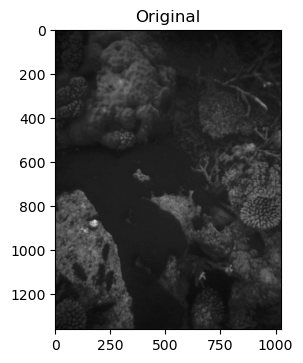

In [9]:
model = LitResnet.load_from_checkpoint("/home/turin/Documents/GitHub/long_term_underwater_vision/model/auto_logs/autoencoder/version_9/checkpoints/epoch=2-step=2400.ckpt")
model = model.to("cuda")
data = train_dataloader
im,y = data.dataset.__getitem__(0)
i1 = im[0]
i2 = im[1]
print(i1.shape)
print(i2.shape)
img1 = torch.unsqueeze(im[0],0)
img1 = img1.to("cuda")
out = model(img1)
out = torch.squeeze(out,0)
# #out2 = torch.squeeze(out2,0)
out1= out.T
# #out2= out2.T
im1 = out1.cpu()
# #im2 = out2.cpu()
im1 = im1.type(torch.float32)
plt.subplot(1,2,1)
plt.title("Original")
generated1 =im1.detach().numpy()
plt.imshow(generated1, cmap="gray")

############################
im,y = data.dataset.__getitem__(0)
print(im[0].shape)
img1 = torch.unsqueeze(im[1],0)
img1 = img1.to("cuda")
out = model(img1)
out = torch.squeeze(out,0)
# #out2 = torch.squeeze(out2,0)
out1= out.T
# #out2= out2.T
im1 = out1.cpu()
# #im2 = out2.cpu()
im1 = im1.type(torch.float32)
plt.subplot(1,2,1)
plt.title("Original")
generated2 =im1.detach().numpy()
plt.imshow(generated2, cmap="gray")

###############
from PIL import Image
import PIL
generated1 = generated1*255
generated1 = generated1.astype(np.uint8)
generated1 = generated1.squeeze()
print(generated1.shape)
generated2 = generated2*255
generated2 = generated2.astype(np.uint8)
generated2 = generated2.squeeze()

i1 = i1.T
i1 = i1.cpu().detach().numpy()
i1 = i1*255
i1 = i1.astype(np.uint8)
i1 = i1.squeeze()

i2 = i2.T
i2 = i2.cpu().detach().numpy()
i2 = i2*255
i2 = i2.astype(np.uint8)
i2 = i2.squeeze()



In [ ]:
#plt.imsave("generated.png", generated, cmap='gray')
from PIL import Image
import PIL
generated255 = generated*255
generated255 = generated255.astype(np.uint8)
generated255 = generated255.squeeze()
pil_image = Image.fromarray(generated255)
pil_image = pil_image.save("generated.png")
#generated

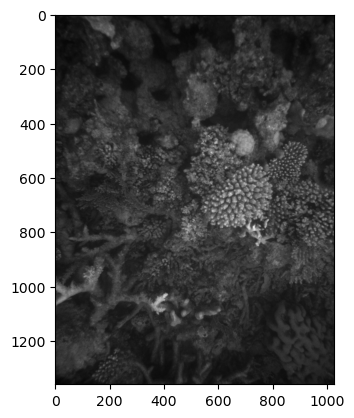

In [8]:
org = im.T
org = org.detach().numpy()
plt.imshow(org, cmap="gray")
original255 = org*255
original255 = original255.astype(np.uint8)
original255 = original255.squeeze()
pil_image = Image.fromarray(original255)
pil_image = pil_image.save("original.png")

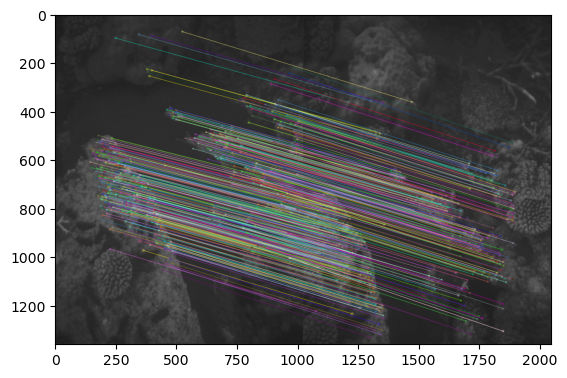

84

In [14]:
import sift_pose_est
x, y , le = sift_pose_est.sift(generated1, generated2 , True)
len(x)

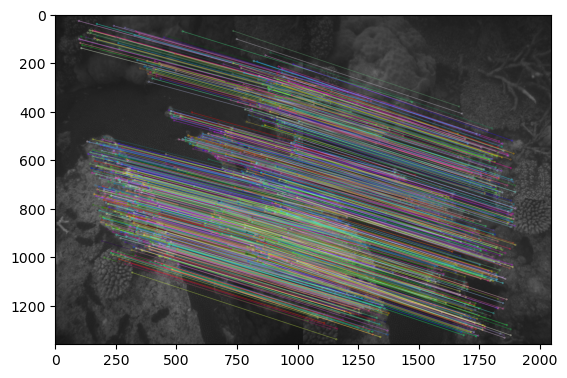

In [11]:
x, y , le = sift_pose_est.sift(i1, i2 , True)

In [13]:
len(x)

109